This code is useful in data loading, visualization and exploration. You are free to modify the code. The code has dependecy on Pytorch Lightning data module. However, you may use Pytorch as well.

**Introduction to Dataset**

The data has a total of 10 classes with 40 samples each. Make sure while working with the data, **esc10=True**. In the Project, you are required to perform 4-fold validation. This dataset has been already divided into 5-folds. The column 'fold' in the metafile denotes the sample in a particular fold. Moreover, first folds is considered for test, rest for 4-fold validation.

In [ ]:
# DL Assignment 2
# Authors: Kopal Rastogi, Ishan Mishra
# Keywords: None
# Assumptions: None

In [ ]:
# Installing the requirements
print('Installing Requirements... ',end='')
!pip install lightning
!pip install wandb
print('Done')

Installing Requirements... Collecting lightning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00
Done


In [ ]:
# Importing Libraries
print('Importing Libraries... ',end='')
import os
import wandb
import warnings
import numpy as np
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, f1_score, auc, classification_report, ConfusionMatrixDisplay
#warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
print('Done')

Importing Libraries... Done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract data
# with zipfile.ZipFile("/content/drive/MyDrive/DL_assignment/Archive.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/DL_assignment")

In [ ]:
# Loading dataset
path = Path('/content/drive/MyDrive/DL_assignment')
df = pd.read_csv('/content/drive/MyDrive/DL_assignment/meta/esc50.csv')

Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


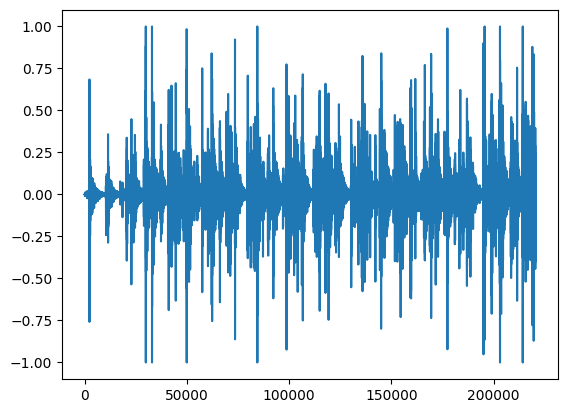

In [ ]:
# Getting list of raw audio files
wavs = list(path.glob('audio/*'))  # List all audio files in the 'audio' directory using pathlib.Path.glob

# Visualizing data
waveform, sample_rate = torchaudio.load(wavs[0])  # Load the waveform and sample rate of the first audio file using torchaudio

print("Shape of waveform: {}".format(waveform.size()))  # Print the shape of the waveform tensor
print("Sample rate of waveform: {}".format(sample_rate))  # Print the sample rate of the audio file

# Plot the waveform using matplotlib
plt.figure()
plt.plot(waveform.t().numpy())  # Transpose and convert the waveform tensor to a NumPy array for plotting

# Display the audio using IPython.display.Audio
ipd.Audio(waveform, rate=sample_rate)  # Create an interactive audio player for the loaded waveform


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        # Initialize CustomDataset object with relevant parameters
        # dataset: "train", "val", or "test"
        # kwargs: Additional parameters like data directory, dataframe, folds, etc.

        # Extract parameters from kwargs
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        # Filter dataframe based on esc_10_flag and data_type
        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        # Get unique categories from the filtered dataframe
        self.categories = sorted(self.data_frame[self.label_column].unique())

        # Initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []

        # Initialize dictionaries for category-to-index and index-to-category mapping
        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        # Populate file names and labels lists by iterating through the dataframe
        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        # Window size for rolling window sample splits (unfold method)
        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        # Split audio files with overlap, pass as stacked tensors tensor with a single label
        path = self.file_names[index]
        audio_file = torchaudio.load(path, format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [ ]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        # Initialize the CustomDataModule with batch size, number of workers, and other parameters
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None):
        # Define datasets for training, validation, and testing during Lightning setup

        # If in 'fit' or None stage, create training and validation datasets
        if stage == 'fit' or stage is None:
            self.training_dataset = CustomDataset(dataset="train", **self.data_module_kwargs)
            self.validation_dataset = CustomDataset(dataset="val", **self.data_module_kwargs)

        # If in 'test' or None stage, create testing dataset
        if stage == 'test' or stage is None:
            self.testing_dataset = CustomDataset(dataset="test", **self.data_module_kwargs)

    def train_dataloader(self):
        # Return DataLoader for training dataset
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        # Return DataLoader for validation dataset
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        # Return DataLoader for testing dataset
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, data):
        """
        Collate function to process a batch of examples and labels.

        Args:
            data: a tuple of 2 tuples with (example, label) where
                example are the split 1 second sub-frame audio tensors per file
                label = the label

        Returns:
            A list containing examples (concatenated tensors) and labels (flattened tensor).
        """
        examples, labels = zip(*data)
        examples = torch.stack(examples)
        examples = examples.reshape(examples.size(0),1,-1)
        labels = torch.flatten(torch.tensor(labels))

        return [examples, labels]


In [ ]:
def print_confusion_matrix(actual, predictions):
  cm = confusion_matrix(actual, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

## Code for the CNN classifier for task 1

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NN1d(nn.Module):
  def __init__(self):
    super(NN1d, self).__init__()
    self.convolution = nn.Sequential(
      nn.Conv1d(in_channels = 1, out_channels = 8, kernel_size = 11, padding = 5),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size = 5),
      nn.BatchNorm1d(8),

      nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 11, padding = 5),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size = 5),
      nn.BatchNorm1d(16),

      nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 7, padding = 3),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size = 5),
      nn.BatchNorm1d(32),

      nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2),
      nn.ReLU(),
      nn.MaxPool1d(kernel_size = 5),
      nn.BatchNorm1d(64),
      nn.AdaptiveAvgPool1d(128)
     )

  def forward(self, x):
    x = self.convolution(x)
    return x

class NN_classifier(NN1d):
  def __init__(self, input_len, output_classes):
    super(NN_classifier, self).__init__()
    self.nn1d = NN1d()
    #self.fc_input = 64*(input_len // 625)
    self.fc_input = 64*128
    self.fc_layers = nn.Sequential(
        nn.Linear(self.fc_input, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes)
    )

  def forward(self, x):
    x = self.nn1d(x)
    x = x.view(-1, self.fc_input)
    x = self.fc_layers(x)
    return x

input_len = 144000  # Length of input data sequence
num_classes = 10

model = NN_classifier(input_len,num_classes).to(device)

summary(model, (1,144000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 8, 144000]              96
              ReLU-2            [-1, 8, 144000]               0
         MaxPool1d-3             [-1, 8, 28800]               0
       BatchNorm1d-4             [-1, 8, 28800]              16
            Conv1d-5            [-1, 16, 28800]           1,424
              ReLU-6            [-1, 16, 28800]               0
         MaxPool1d-7             [-1, 16, 5760]               0
       BatchNorm1d-8             [-1, 16, 5760]              32
            Conv1d-9             [-1, 32, 5760]           3,616
             ReLU-10             [-1, 32, 5760]               0
        MaxPool1d-11             [-1, 32, 1152]               0
      BatchNorm1d-12             [-1, 32, 1152]              64
           Conv1d-13             [-1, 64, 1152]          10,304
             ReLU-14             [-1, 6

In [ ]:

epochs = 100

for cross_val in range(2,6):
  test_samp = 1 #""" Do not change this!! """
  valid_samp = cross_val # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
  batch_size = 32 # Free to change
  num_workers = 1 # Free to change
  custom_data_module = CustomDataModule(batch_size=batch_size,
                                        num_workers=num_workers,
                                        data_directory=path,
                                        data_frame=df,
                                        validation_fold=valid_samp,
                                        testing_fold=test_samp,  # set to 0 for no test set
                                        esc_10_flag=True,
                                        file_column='filename',
                                        label_column='category',
                                        sampling_rate=44100,
                                        new_sampling_rate=16000,  # new sample rate for input
                                        sample_length_seconds=1  # new length of input in seconds
                                        )

  custom_data_module.setup()

  model = NN_classifier(input_len,num_classes).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = 0.01)

  wandb.init(project = "Classification_convolution", name = f'CNN-validation_fold {cross_val}')
  ######################### TRAINING LOOP ######################################
  for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for inputs, labels in custom_data_module.train_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * inputs.size(0)

          # Calculate the number of correct predictions
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == labels).sum().item()

      # Calculate average loss and accuracy
    epoch_loss = total_loss / len(custom_data_module.training_dataset)
    epoch_accuracy = correct_predictions / len(custom_data_module.training_dataset)

    print(f'Epoch {epoch+1}/{epochs} :: Training Loss: {epoch_loss:.4f}, Training Accuracy: {(epoch_accuracy*100):.4f}%')
  ########################### VALIDATION LOOP ##################################
    model.eval()
    total = 0
    correct = 0
    iter = 0

    with torch.no_grad():
      for inputs, labels in custom_data_module.val_dataloader():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        iter += 1
        total += labels.size(0)
        if (iter%10 == 0):
          print(f'iter {iter}  total = {total} correct = {correct}')

    val_accuracy = correct/total
    print(f'Validation Accuracy : {val_accuracy * 100:.2f}%')

    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_accuracy*100, "Validation Accuracy": val_accuracy*100})
  wandb.finish()

  ########################### TEST LOOP ########################################
  total = 0
  correct = 0
  iter = 0

  labels_list = []
  predictions_list = []
  probabilities_list = []

  with torch.no_grad():
    for inputs, labels in custom_data_module.test_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      probabilities_list.extend(outputs.cpu().numpy())

      _, predicted = torch.max(outputs.data, 1)
      predictions_list.extend(predicted.cpu().numpy())
      labels_list.extend(labels.cpu().numpy())

  accuracy = accuracy_score(labels_list, predictions_list)
  cm = confusion_matrix(labels_list, predictions_list)
  f1_scores = classification_report(labels_list, predictions_list)
  print('\n')

  print(f"Test Accuracy : {accuracy*100:.3f}%")
  print(f"F1 score : \n{f1_scores}")
  print_confusion_matrix(labels_list, predictions_list)
  print('\n')

  fpr = {}
  tpr = {}
  threshold ={}
  for j in range(num_classes):
      fpr[j], tpr[j], threshold[j] = roc_curve(labels_list, np.array(probabilities_list)[:,j], pos_label=j)
      plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
  plt.legend()
  plt.title(f'AUC-ROC curve: Fold No.{cross_val}')
  plt.show()

  print("\n================================================================================\n")

## Code for the transformer based classifier

In [ ]:
import math

class MultiHeadAttention(nn.Module):
  def __init__(self, embedding, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.embedding = embedding
    assert embedding % self.num_heads == 0

    self.head_dim = embedding // num_heads

    self.query_mlp = nn.Linear(embedding, embedding)
    self.key_mlp = nn.Linear(embedding, embedding)
    self.value_mlp = nn.Linear(embedding, embedding)
    self.out_mlp = nn.Linear(embedding, embedding)

  def forward(self, query, key, value):
    batch_size = query.shape[0]
    query_len, key_len, value_len = query.shape[1], key.shape[1], value.shape[1]

    value = self.value_mlp(value)
    key = self.key_mlp(key)
    query = self.query_mlp(query)

    value = value.reshape(batch_size, value_len, self.num_heads, self.head_dim)
    key = key.reshape(batch_size, key_len, self.num_heads, self.head_dim)
    query = query.reshape(batch_size, key_len, self.num_heads, self.head_dim)

    alignment_score = torch.einsum("nqhd,nkhd->nhqk", [query, key])

    attention = torch.softmax(alignment_score / (self.embedding**(1/2)), dim = 3)

    output = torch.einsum("nhql,nlhd->nqhd", [attention,value])
    output = output.reshape(batch_size, query_len, self.num_heads*self.head_dim)
    output = self.out_mlp(output)

    return output


class EncoderLayer(nn.Module):
  def __init__(self, embedding, num_heads):
    super(EncoderLayer, self).__init__()
    self.multi_head_attention = MultiHeadAttention(embedding, num_heads)
    self.fc_layer = nn.Sequential(
        nn.Linear(embedding, 4 * embedding),
        nn.ReLU(),
        nn.Linear(4 * embedding, embedding)
    )
    self.layer_norm1 = nn.LayerNorm(embedding)
    self.layer_norm2 = nn.LayerNorm(embedding)

  def forward(self, x):
    attention_output = self.multi_head_attention(x, x, x)
    attention_output = self.layer_norm1(x + attention_output)
    fc_output = self.fc_layer(attention_output)
    fc_output = self.layer_norm2(attention_output + fc_output)
    return fc_output

class TransformerEncoder(nn.Module):
  def __init__(self, embedding, num_heads, num_layers):
    super(TransformerEncoder, self).__init__()
    self.encoder_layers = nn.ModuleList([EncoderLayer(embedding, num_heads) for _ in range(num_layers)])
    self.cls_token = nn.Parameter(torch.randn(1, 1, embedding))

  def forward(self, x):
    x = torch.cat((self.cls_token.expand(x.size(0), -1, -1), x), dim=1)
    for layer in self.encoder_layers:
      x = layer(x)
    return x

class TransformerClassifier(NN1d):
  def __init__(self, embedding, num_heads, num_layers, num_classes):
    super(TransformerClassifier, self).__init__()
    self.conv = NN1d()
    self.encoder = TransformerEncoder(embedding, num_heads, num_layers)
    self.flatten = nn.Flatten()
    self.mlp1 = nn.Linear(embedding, 64)
    self.mlp_head = nn.Linear(64, 10)

  def PositionalEncoding(self, x):
    length = x.shape[1]
    d_model = x.shape[2]
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                          -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe.unsqueeze(0)

  def forward(self, x):
    x = self.conv(x)
    pos = self.PositionalEncoding(x).to(device)
    x = self.encoder(x+pos)
    #print('before ',x.shape)
    #x = self.flatten(x)
    #print('after ',x.shape)
    cls_token = x[:, 0, :]  # Get <cls> token
    output = self.mlp1(cls_token)
    output = self.mlp_head(output)
    return output

100%|██████████| 80/80 [00:00<00:00, 7200.52it/s]


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/100 :: Training Loss: 2.2760, Training Accuracy: 15.8333
Validation Accuracy : 10.00%
Epoch 2/100 :: Training Loss: 1.8565, Training Accuracy: 33.3333
Validation Accuracy : 22.50%
Epoch 3/100 :: Training Loss: 1.6263, Training Accuracy: 34.5833
Validation Accuracy : 21.25%
Epoch 4/100 :: Training Loss: 1.4289, Training Accuracy: 49.5833
Validation Accuracy : 18.75%
Epoch 5/100 :: Training Loss: 1.1824, Training Accuracy: 55.8333
Validation Accuracy : 21.25%
Epoch 6/100 :: Training Loss: 1.0652, Training Accuracy: 62.0833
Validation Accuracy : 38.75%
Epoch 7/100 :: Training Loss: 1.0199, Training Accuracy: 61.6667
Validation Accuracy : 46.25%
Epoch 8/100 :: Training Loss: 0.7741, Training Accuracy: 70.8333
Validation Accuracy : 46.25%
Epoch 9/100 :: Training Loss: 0.6902, Training Accuracy: 78.7500
Validation Accuracy : 51.25%
Epoch 10/100 :: Training Loss: 0.5098, Training Accuracy: 85.4167
Validation Accuracy : 55.00%
Epoch 11/100 :: Training Loss: 0.4617, Training Accuracy: 8

Train Accuracy,▁▃▅▆▇▇▇▇▇▇█████▇█▇▇▇████████████████████
Train Loss,█▆▄▃▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▄▅▆▇▆▆▇█▇▆▇▇▇▄▆▆▆▇▇▇▇▆▇▇▇▆▆▇▇▇▆▆▆▆▆▅▅▅
Train Accuracy,100.0
Train Loss,0.00217
Validation Accuracy,47.5




Test Accuracy : 51.250%
F1 score : 
              precision    recall  f1-score   support

           0       0.67      0.25      0.36         8
           1       0.50      0.50      0.50         8
           2       0.55      0.75      0.63         8
           3       0.43      0.38      0.40         8
           4       0.00      0.00      0.00         8
           5       0.50      0.12      0.20         8
           6       0.50      0.88      0.64         8
           7       1.00      0.88      0.93         8
           8       0.38      0.62      0.48         8
           9       0.50      0.75      0.60         8

    accuracy                           0.51        80
   macro avg       0.50      0.51      0.47        80
weighted avg       0.50      0.51      0.47        80



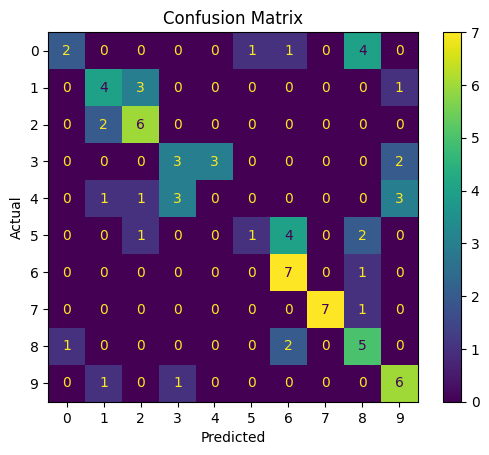

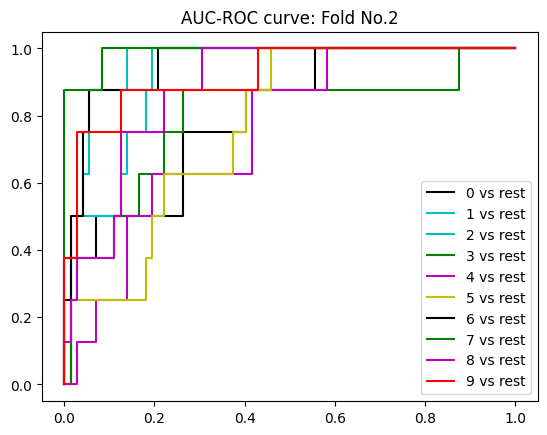

100%|██████████| 80/80 [00:00<00:00, 6959.19it/s]
wandb: Currently logged in as: dipan009. Use `wandb login --relogin` to force relogin


Epoch 1/100 :: Training Loss: 2.3533, Training Accuracy: 12.5000
Validation Accuracy : 10.00%
Epoch 2/100 :: Training Loss: 1.9167, Training Accuracy: 28.3333
Validation Accuracy : 10.00%
Epoch 3/100 :: Training Loss: 1.6247, Training Accuracy: 40.4167
Validation Accuracy : 10.00%
Epoch 4/100 :: Training Loss: 1.4911, Training Accuracy: 46.6667
Validation Accuracy : 10.00%
Epoch 5/100 :: Training Loss: 1.2779, Training Accuracy: 56.6667
Validation Accuracy : 13.75%
Epoch 6/100 :: Training Loss: 1.1039, Training Accuracy: 62.9167
Validation Accuracy : 18.75%
Epoch 7/100 :: Training Loss: 0.9526, Training Accuracy: 66.6667
Validation Accuracy : 38.75%
Epoch 8/100 :: Training Loss: 0.8774, Training Accuracy: 68.7500
Validation Accuracy : 40.00%
Epoch 9/100 :: Training Loss: 0.6378, Training Accuracy: 80.4167
Validation Accuracy : 51.25%
Epoch 10/100 :: Training Loss: 0.5373, Training Accuracy: 82.9167
Validation Accuracy : 48.75%
Epoch 11/100 :: Training Loss: 0.6173, Training Accuracy: 8

Train Accuracy,▁▃▅▅▆▇▇█████▇███████████████████████████
Train Loss,█▆▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▂▅▆▆▇▇██▇▇▇▇██▇▇▇▇▇▇▇████▇▇▇▇▇█▇▇█████
Train Accuracy,100.0
Train Loss,0.00044
Validation Accuracy,58.75




Test Accuracy : 65.000%
F1 score : 
              precision    recall  f1-score   support

           0       1.00      0.38      0.55         8
           1       0.60      0.75      0.67         8
           2       0.83      0.62      0.71         8
           3       0.60      0.38      0.46         8
           4       0.40      0.50      0.44         8
           5       0.67      0.75      0.71         8
           6       0.60      0.75      0.67         8
           7       0.89      1.00      0.94         8
           8       0.60      0.75      0.67         8
           9       0.62      0.62      0.62         8

    accuracy                           0.65        80
   macro avg       0.68      0.65      0.64        80
weighted avg       0.68      0.65      0.64        80



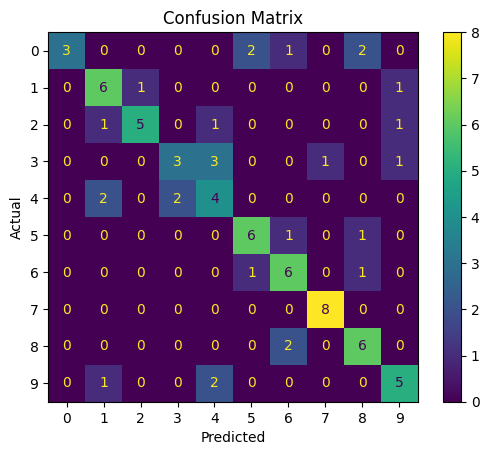

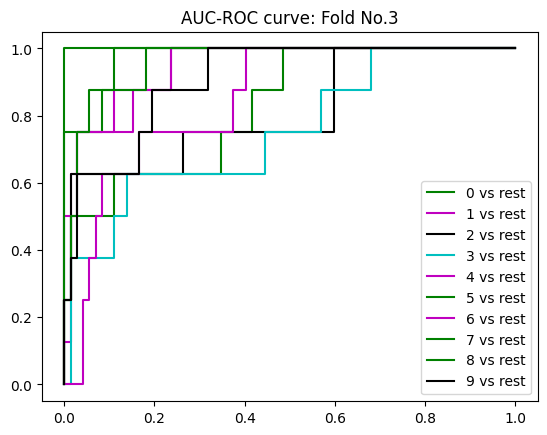

100%|██████████| 80/80 [00:00<00:00, 5719.08it/s]


Epoch 1/100 :: Training Loss: 2.3364, Training Accuracy: 15.0000
Validation Accuracy : 10.00%
Epoch 2/100 :: Training Loss: 1.8364, Training Accuracy: 37.5000
Validation Accuracy : 10.00%
Epoch 3/100 :: Training Loss: 1.5908, Training Accuracy: 39.5833
Validation Accuracy : 13.75%
Epoch 4/100 :: Training Loss: 1.4453, Training Accuracy: 50.4167
Validation Accuracy : 17.50%
Epoch 5/100 :: Training Loss: 1.2281, Training Accuracy: 60.8333
Validation Accuracy : 21.25%
Epoch 6/100 :: Training Loss: 1.1940, Training Accuracy: 58.3333
Validation Accuracy : 30.00%
Epoch 7/100 :: Training Loss: 0.9939, Training Accuracy: 64.1667
Validation Accuracy : 38.75%
Epoch 8/100 :: Training Loss: 0.8788, Training Accuracy: 71.2500
Validation Accuracy : 55.00%
Epoch 9/100 :: Training Loss: 0.8464, Training Accuracy: 69.5833
Validation Accuracy : 47.50%
Epoch 10/100 :: Training Loss: 0.7625, Training Accuracy: 74.1667
Validation Accuracy : 50.00%
Epoch 11/100 :: Training Loss: 0.6178, Training Accuracy: 7

Train Accuracy,▁▃▅▆▆▇▇▇█▇████▇▇████████████████████████
Train Loss,█▆▅▄▃▂▂▂▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▂▄█▇▇▇▇█▇▇▇▇█▇▇█▇▆▇▇▇▇▇▇▆▇▇▆▇▇▆▇▇▇▇▇▇▇▇
Train Accuracy,100.0
Train Loss,0.00055
Validation Accuracy,48.75




Test Accuracy : 56.250%
F1 score : 
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.58      0.88      0.70         8
           2       0.50      0.12      0.20         8
           3       0.67      0.50      0.57         8
           4       0.33      0.12      0.18         8
           5       0.50      0.38      0.43         8
           6       0.38      1.00      0.55         8
           7       0.78      0.88      0.82         8
           8       0.67      0.75      0.71         8
           9       0.75      0.75      0.75         8

    accuracy                           0.56        80
   macro avg       0.57      0.56      0.52        80
weighted avg       0.57      0.56      0.52        80



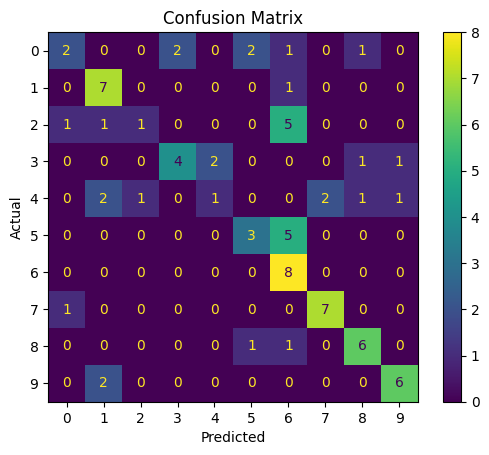

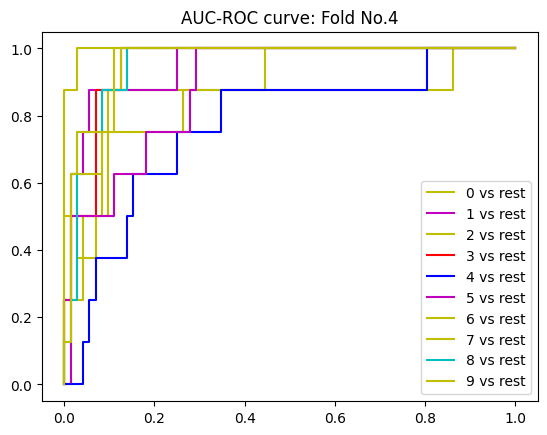

100%|██████████| 80/80 [00:00<00:00, 3991.15it/s]


Epoch 1/100 :: Training Loss: 2.3508, Training Accuracy: 12.9167
Validation Accuracy : 13.75%
Epoch 2/100 :: Training Loss: 1.8959, Training Accuracy: 28.3333
Validation Accuracy : 10.00%
Epoch 3/100 :: Training Loss: 1.6670, Training Accuracy: 40.8333
Validation Accuracy : 13.75%
Epoch 4/100 :: Training Loss: 1.4515, Training Accuracy: 47.5000
Validation Accuracy : 10.00%
Epoch 5/100 :: Training Loss: 1.2766, Training Accuracy: 47.5000
Validation Accuracy : 23.75%
Epoch 6/100 :: Training Loss: 1.1327, Training Accuracy: 58.3333
Validation Accuracy : 26.25%
Epoch 7/100 :: Training Loss: 1.0615, Training Accuracy: 55.4167
Validation Accuracy : 37.50%
Epoch 8/100 :: Training Loss: 0.9707, Training Accuracy: 60.8333
Validation Accuracy : 47.50%
Epoch 9/100 :: Training Loss: 0.8189, Training Accuracy: 69.1667
Validation Accuracy : 40.00%
Epoch 10/100 :: Training Loss: 0.7574, Training Accuracy: 69.5833
Validation Accuracy : 50.00%
Epoch 11/100 :: Training Loss: 0.6826, Training Accuracy: 7

Train Accuracy,▁▃▅▅▆▆█▇██▇█▇█████████████████████▇▇████
Train Loss,█▆▄▄▃▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
Validation Accuracy,▁▁▃▆▅▆▇▇█▇▅▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▃▆▅▇█▇█
Train Accuracy,100.0
Train Loss,0.0089
Validation Accuracy,60.0




Test Accuracy : 50.000%
F1 score : 
              precision    recall  f1-score   support

           0       0.57      0.50      0.53         8
           1       0.42      0.62      0.50         8
           2       0.33      0.50      0.40         8
           3       0.60      0.38      0.46         8
           4       0.00      0.00      0.00         8
           5       0.33      0.12      0.18         8
           6       0.44      0.88      0.58         8
           7       1.00      0.75      0.86         8
           8       0.30      0.38      0.33         8
           9       0.88      0.88      0.88         8

    accuracy                           0.50        80
   macro avg       0.49      0.50      0.47        80
weighted avg       0.49      0.50      0.47        80



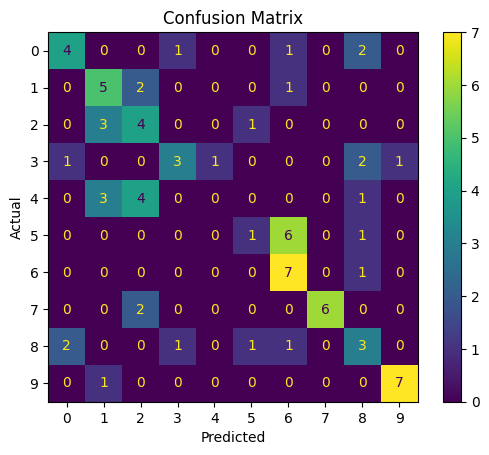

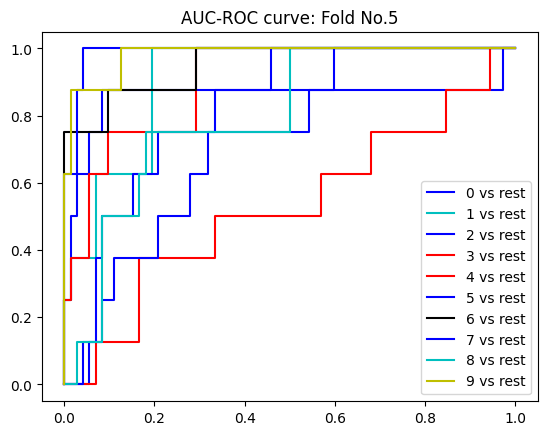

In [ ]:
#####################  TRANSFORMER MODEL WITH 4 HEADS ##########################
embedding = 128
num_heads = 4
num_layers = 2
num_classes = 10
epochs = 100

for cross_val in range(2,6): #performing cross validation

  test_samp = 1 #""" Do not change this!! """
  valid_samp = cross_val # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
  batch_size = 32 # Free to change
  num_workers = 1 # Free to change
  custom_data_module = CustomDataModule(batch_size=batch_size,
                                        num_workers=num_workers,
                                        data_directory=path,
                                        data_frame=df,
                                        validation_fold=valid_samp,
                                        testing_fold=test_samp,  # set to 0 for no test set
                                        esc_10_flag=True,
                                        file_column='filename',
                                        label_column='category',
                                        sampling_rate=44100,
                                        new_sampling_rate=16000,  # new sample rate for input
                                        sample_length_seconds=1  # new length of input in seconds
                                        )

  custom_data_module.setup()
  transformer_model_4heads = TransformerClassifier(embedding, num_heads, num_layers, num_classes).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(transformer_model_4heads.parameters(), lr = 0.001)

  wandb.init(project = "Classification_Transformer 4 heads", name = f'transformer-validation_fold {cross_val}')
  ############################# TRAINING LOOP ##################################
  for epoch in range(epochs):
    transformer_model_4heads.train()
    total_loss = 0
    correct_predictions = 0
    for inputs, labels in custom_data_module.train_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = transformer_model_4heads(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * inputs.size(0)

          # Calculate the number of correct predictions
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == labels).sum().item()

      # Calculate average loss and accuracy
    epoch_loss = total_loss / len(custom_data_module.training_dataset)
    epoch_accuracy = correct_predictions / len(custom_data_module.training_dataset)

    print(f'Epoch {epoch+1}/{epochs} :: Training Loss: {epoch_loss:.4f}, Training Accuracy: {(epoch_accuracy*100):.4f}')
  ####################### VALIDATION LOOP ######################################
    transformer_model_4heads.eval()
    total = 0
    correct = 0

    with torch.no_grad():
      for inputs, labels in custom_data_module.val_dataloader():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = transformer_model_4heads(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    val_accuracy = correct/total
    print(f'Validation Accuracy : {val_accuracy * 100:.2f}%')

    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_accuracy*100, "Validation Accuracy": val_accuracy*100})
  wandb.finish()

  ########################### TESTING LOOP #####################################

  labels_list = []
  predictions_list = []
  probabilities_list = []

  with torch.no_grad():
    for inputs, labels in custom_data_module.test_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = transformer_model_4heads(inputs)
      probabilities_list.extend(outputs.cpu().numpy())

      _, predicted = torch.max(outputs.data, 1)
      predictions_list.extend(predicted.cpu().numpy())
      labels_list.extend(labels.cpu().numpy())

  accuracy = accuracy_score(labels_list, predictions_list)
  cm = confusion_matrix(labels_list, predictions_list)
  f1_scores = classification_report(labels_list, predictions_list)
  print('\n')

  print(f"Test Accuracy : {accuracy*100:.3f}%")
  print(f"F1 score : \n{f1_scores}")
  print_confusion_matrix(labels_list, predictions_list)
  print('\n')
  fpr = {}
  tpr = {}
  threshold ={}
  for j in range(num_classes):
      fpr[j], tpr[j], threshold[j] = roc_curve(labels_list, np.array(probabilities_list)[:,j], pos_label=j)
      plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
  plt.legend()
  plt.title(f'AUC-ROC curve: Fold No.{cross_val}')
  plt.show()
  print("\n============================================================================\n")

In [ ]:
#################### TRANSFORMER MODEL WITH 2 HEADS ############################

embedding = 128
num_heads = 2
num_layers = 2
num_classes = 10
epochs = 100

for cross_val in range(2,6): #performing cross validation

  test_samp = 1 #""" Do not change this!! """
  valid_samp = cross_val # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
  batch_size = 32 # Free to change
  num_workers = 1 # Free to change
  custom_data_module = CustomDataModule(batch_size=batch_size,
                                        num_workers=num_workers,
                                        data_directory=path,
                                        data_frame=df,
                                        validation_fold=valid_samp,
                                        testing_fold=test_samp,  # set to 0 for no test set
                                        esc_10_flag=True,
                                        file_column='filename',
                                        label_column='category',
                                        sampling_rate=44100,
                                        new_sampling_rate=16000,  # new sample rate for input
                                        sample_length_seconds=1  # new length of input in seconds
                                        )

  custom_data_module.setup()

  transformer_model_2heads = TransformerClassifier(embedding, num_heads, num_layers, num_classes).to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(transformer_model_2heads.parameters(), lr = 0.001)
  wandb.init(project = "Classification_Transformer 2 heads", name = f'transformer-validation_fold {cross_val}')
  ############################# TRAINING LOOP ##################################
  for epoch in range(epochs):
    transformer_model_2heads.train()
    total_loss = 0
    correct_predictions = 0
    for inputs, labels in custom_data_module.train_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = transformer_model_2heads(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * inputs.size(0)

          # Calculate the number of correct predictions
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == labels).sum().item()

      # Calculate average loss and accuracy
    epoch_loss = total_loss / len(custom_data_module.training_dataset)
    epoch_accuracy = correct_predictions / len(custom_data_module.training_dataset)

    print(f'Epoch {epoch+1}/{epochs} :: Training Loss: {epoch_loss:.4f}, Training Accuracy: {(epoch_accuracy*100):.4f}')
  ####################### VALIDATION LOOP ######################################
    transformer_model_2heads.eval()
    total = 0
    correct = 0

    with torch.no_grad():
      for inputs, labels in custom_data_module.val_dataloader():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = transformer_model_2heads(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    val_accuracy = correct/total
    print(f'Validation Accuracy : {val_accuracy * 100:.2f}%')

    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_accuracy*100, "Validation Accuracy": val_accuracy*100})
  wandb.finish()

  ########################### TESTING LOOP #####################################

  labels_list = []
  predictions_list = []
  probabilities_list = []

  with torch.no_grad():
    for inputs, labels in custom_data_module.test_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = transformer_model_2heads(inputs)
      probabilities_list.extend(outputs.cpu().numpy())

      _, predicted = torch.max(outputs.data, 1)
      predictions_list.extend(predicted.cpu().numpy())
      labels_list.extend(labels.cpu().numpy())

  accuracy = accuracy_score(labels_list, predictions_list)
  cm = confusion_matrix(labels_list, predictions_list)
  f1_scores = classification_report(labels_list, predictions_list)
  print('\n')

  print(f"Test Accuracy : {accuracy*100:.3f}%")
  print(f"F1 score : \n{f1_scores}")
  print_confusion_matrix(labels_list, predictions_list)
  print('\n')
  fpr = {}
  tpr = {}
  threshold ={}
  for j in range(num_classes):
      fpr[j], tpr[j], threshold[j] = roc_curve(labels_list, np.array(probabilities_list)[:,j], pos_label=j)
      plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
  plt.legend()
  plt.title(f'AUC-ROC curve: Fold No.{cross_val}')
  plt.show()
  print("\n============================================================================\n")

In [ ]:
##################### TRANSFORMER MODEL WITH 1 HEAD ############################

embedding = 128
num_heads = 1
num_layers = 2
num_classes = 10
epochs = 100

for cross_val in range(2,6): #performing cross validation

  test_samp = 1 #""" Do not change this!! """
  valid_samp = cross_val # Use any value ranging from 2 to 5 for k-fold validation (valid_fold)
  batch_size = 32 # Free to change
  num_workers = 1 # Free to change
  custom_data_module = CustomDataModule(batch_size=batch_size,
                                        num_workers=num_workers,
                                        data_directory=path,
                                        data_frame=df,
                                        validation_fold=valid_samp,
                                        testing_fold=test_samp,  # set to 0 for no test set
                                        esc_10_flag=True,
                                        file_column='filename',
                                        label_column='category',
                                        sampling_rate=44100,
                                        new_sampling_rate=16000,  # new sample rate for input
                                        sample_length_seconds=1  # new length of input in seconds
                                        )

  custom_data_module.setup()
  transformer_model_1heads = TransformerClassifier(embedding, num_heads, num_layers, num_classes).to(device)
  summary(transformer_model_1heads, (1,144000))

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(transformer_model_1heads.parameters(), lr = 0.001)
  wandb.init(project = "Classification_Transformer 1 head", name = f'transformer-validation_fold {cross_val}')
  ############################# TRAINING LOOP ##################################
  for epoch in range(epochs):
    transformer_model_1heads.train()
    total_loss = 0
    correct_predictions = 0
    for inputs, labels in custom_data_module.train_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = transformer_model_1heads(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * inputs.size(0)

          # Calculate the number of correct predictions
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == labels).sum().item()

      # Calculate average loss and accuracy
    epoch_loss = total_loss / len(custom_data_module.training_dataset)
    epoch_accuracy = correct_predictions / len(custom_data_module.training_dataset)

    print(f'Epoch {epoch+1}/{epochs} :: Training Loss: {epoch_loss:.4f}, Training Accuracy: {(epoch_accuracy*100):.4f}')
  ####################### VALIDATION LOOP ######################################
    transformer_model_1heads.eval()
    total = 0
    correct = 0

    with torch.no_grad():
      for inputs, labels in custom_data_module.val_dataloader():
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = transformer_model_1heads(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    val_accuracy = correct/total
    print(f'Validation Accuracy : {val_accuracy * 100:.2f}%')

    wandb.log({"Train Loss": epoch_loss, "Train Accuracy": epoch_accuracy*100, "Validation Accuracy": val_accuracy*100})
  wandb.finish()

  ########################### TESTING LOOP #####################################

  labels_list = []
  predictions_list = []
  probabilities_list = []

  with torch.no_grad():
    for inputs, labels in custom_data_module.test_dataloader():
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = transformer_model_1heads(inputs)
      probabilities_list.extend(outputs.cpu().numpy())

      _, predicted = torch.max(outputs.data, 1)
      predictions_list.extend(predicted.cpu().numpy())
      labels_list.extend(labels.cpu().numpy())

  accuracy = accuracy_score(labels_list, predictions_list)
  cm = confusion_matrix(labels_list, predictions_list)
  f1_scores = classification_report(labels_list, predictions_list)
  print('\n')

  print(f"Test Accuracy : {accuracy*100:.3f}%")
  print(f"F1 score : \n{f1_scores}")
  print_confusion_matrix(labels_list, predictions_list)
  print('\n')
  fpr = {}
  tpr = {}
  threshold ={}
  for j in range(num_classes):
      fpr[j], tpr[j], threshold[j] = roc_curve(labels_list, np.array(probabilities_list)[:,j], pos_label=j)
      plt.plot(fpr[j], tpr[j], label = f'{j} vs rest',color = np.random.choice(['r','g','b','y','c','m','k']))
  plt.legend()
  plt.title(f'AUC-ROC curve: Fold No.{cross_val}')
  plt.show()
  print("\n============================================================================\n")